# 🏠 부동산 실거래가 예측 대회 - KKH - MODEL
> - 학습, 예측, 평가를 진행한다.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [65]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math
import joblib

# Model
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoost
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

# Optuna
from optuna import create_study
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
import optuna

import eli5
from eli5.sklearn import PermutationImportance

# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [66]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # 서울시 가계대출규모
kb = pd.read_csv('data/jaemyung_kb.csv', encoding='utf-8')
price = pd.read_csv('data/jimi_prices_by_coordinates.csv', encoding='utf-8')

## kb부동산지수 추가

In [67]:
train = pd.merge(train, kb, left_on='계약년월', right_on='date', how='left')
train = train.drop(columns=['date'])

test = pd.merge(test, kb, left_on='계약년월', right_on='date', how='left')
test = test.drop(columns=['date'])

## 세대별주차대수 추가

In [68]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

## 서울시_가계대출 추가

In [70]:
# '계약년월'과 '년월'이 일치하는 경우 '서울시_가계대출' 정보를 train에 병합
train = train.merge(loan, how='left', left_on='계약년월', right_on='년월')
# '년월' 열은 필요 없으므로 삭제
train.drop(columns=['년월'], inplace=True)

test = test.merge(loan, how='left', left_on='계약년월', right_on='년월')
test.drop(columns=['년월'], inplace=True)

## top_apt 추가

- 동+아파트명 기준, 평균 가격이 20억 이상인 그룹에 속하면 1, 아니면 0

In [71]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

## 국민평수 추가

- 전용면적이 90이하이면 1, 아니면 0

In [72]:
train['국민평수'] = train['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0).astype('category')
test['국민평수'] = test['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0).astype('category')

## 층 이상치 처리

- -2, 65, 67, 68, 69층에 대한 정보를 이상치로 간주하고 제거

In [73]:
train = train[~train['층'].isin([-2, 65, 67, 68, 69])]

## 아파트명 처리

- 유명한 브랜드 아파트명이 포함되어 있다면, 브랜드명으로 정리 및 통일

In [74]:
def update_apt(df):
    # 아파트명 리스트
    apartment_names = [
        "힐스테이트", "푸르지오", "e편한세상", "롯데캐슬", "래미안", "아이파크", "위브", "한화포레나", 
        "자이", "호반베르디움", "더샵", "서희스타힐스", "한라비발디", "우미린", "하늘채", "더플래티넘", 
        "센트레빌", "코아루", "동문굿모닝힐", "리슈빌", "SK뷰", "스위첸", "데시앙", "벽산블루밍"
    ]

    df['아파트명'].fillna('Missing', inplace=True)

    # 아파트명 변경
    changed_count = 0
    for name in apartment_names:
        mask = df['아파트명'].str.contains(name)
        changed_count += mask.sum()  # 변경된 행의 개수 더하기
        df.loc[mask, '아파트명'] = name
    return changed_count

changed_count = update_apt(train)
print(f"train의 '아파트명' 변경된 데이터 수: {changed_count}")

changed_count = update_apt(test)
print(f"test의 '아파트명' 변경된 데이터 수: {changed_count}")


train의 '아파트명' 변경된 데이터 수: 179263
test의 '아파트명' 변경된 데이터 수: 2562


## 사용할 피처 선택

- 아직 확정은 아니고, 다중공선성 확인해봐야 함.

In [75]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
train = train[selected_feature_list]

## 모든 결측치 처리

- 수치형 결측치는 -999로 대체
- 범주형 결측치는 'Missing'으로 대체

In [76]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # 수치형 피처의 결측치를 -999으로 대체
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,좌표X,좌표Y,target,1번째_가까운_역_이름,1번째_가까운_역_거리,kb부동산지수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과
0,개포6차우성,79.97,282438.7,3,1987,강남구,개포동,127.056859,37.476276,124000,구룡,1187.672025,88.4,20.0,250.0,-999.0
1,개포6차우성,79.97,282438.7,4,1987,강남구,개포동,127.056859,37.476276,123500,구룡,1187.672025,88.4,20.0,250.0,-999.0
2,개포6차우성,54.98,282438.7,5,1987,강남구,개포동,127.056859,37.476276,91500,구룡,1187.672025,88.4,20.0,250.0,-999.0
3,개포6차우성,79.97,283669.8,4,1987,강남구,개포동,127.056859,37.476276,130000,구룡,1187.672025,118.0,20.0,250.0,-999.0
4,개포6차우성,79.97,283669.8,2,1987,강남구,개포동,127.056859,37.476276,117000,구룡,1187.672025,118.0,20.0,250.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,59.94,-999.0,11,1998,은평구,구산동,126.905543,37.612989,20000,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118818,갈현현대,59.94,-999.0,10,1998,은평구,구산동,126.905543,37.612989,20000,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118819,갈현현대,84.83,-999.0,20,1998,은평구,구산동,126.905543,37.612989,28000,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118820,갈현현대,84.83,-999.0,8,1998,은평구,구산동,126.905543,37.612989,29000,구산,1048.367837,-999.0,171.0,141.0,-999.0


In [77]:
print((train.isnull().mean() * 100).to_string())

아파트명                      0.0
전용면적(㎡)                   0.0
서울시_가계대출                  0.0
층                         0.0
건축년도                      0.0
구                         0.0
동                         0.0
좌표X                       0.0
좌표Y                       0.0
target                    0.0
1번째_가까운_역_이름              0.0
1번째_가까운_역_거리              0.0
kb부동산지수                   0.0
k-전용면적별세대현황(60㎡이하)        0.0
k-전용면적별세대현황(60㎡~85㎡이하)    0.0
k-135㎡초과                  0.0


## 수치형과 범주형으로 구분

In [78]:
SEED = 53682552
TARGET = 'target'
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

# 범주형 변수를 문자열로 변환
for col in CAT_COLS:
    train[col] = train[col].astype(str)

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '좌표X', '좌표Y', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
Categoric Cols --> ['아파트명', '구', '동', '1번째_가까운_역_이름']


## 상관 관계 확인(다중공선성 확인)

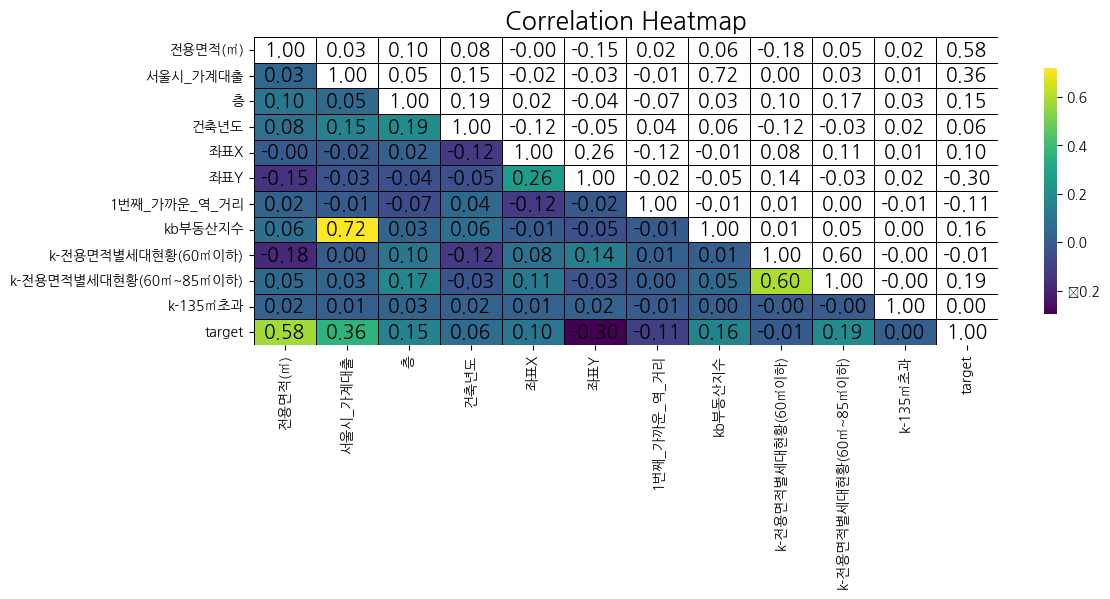

In [79]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

## 학습 및 평가

- 수치형: min-max 스케일러
- 범주형: label 인코딩
- 사용 모델: XGB, CAT, XGB+CAT
- 교차검증 적용
- 하이퍼파라미터 찾기: 옵튜나 사용
- 평가 척도: RMSE (R2도 함께 사용하여 참고함)

## XGBoost로만 평가

In [80]:
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 범주형 열에 대한 레이블 인코딩
def label_encode_columns(X, cols):
    for col in cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    return X

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), NUMERIC_COLS),
        ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
    ], remainder='passthrough')

# Optuna를 사용한 XGBoost 하이퍼파라미터 최적화
def objective_xgb(trial):
    model = XGBRegressor(
        # n_estimators=trial.suggest_int('n_estimators', 300, 3000),
        # max_depth=trial.suggest_int('max_depth', 5, 30),
        # learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        # subsample=trial.suggest_float('subsample', 0.5, 1.0),
        # colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=SEED,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return -np.mean(cv_scores)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params

# 마감까지 시간이 없으니, 그냥 한번만 돌린다;;
n_trials = 1
xgb_best_params = optimize_model(objective_xgb, n_trials)
print(f"@@ XGBoost best params: {xgb_best_params}")

# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(**xgb_best_params, random_state=SEED)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-np.mean(cv_scores_xgb))
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 결과 저장 및 출력
results = {'XGBoost': {'R2 Score': r2_xgb, 'RMSE': rmse_xgb}}
for model_name, metrics in results.items():
    print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  / RMSE: {metrics['RMSE']:.4f}")

[I 2024-07-22 10:19:32,533] A new study created in memory with name: no-name-3559d091-3a65-4e26-bfd5-5cc34cad1576
[I 2024-07-22 10:19:38,059] Trial 0 finished with value: 88769810.10156366 and parameters: {}. Best is trial 0 with value: 88769810.10156366.


@@ XGBoost best params: {}
@@ model: XGBoost  /  R2: 0.9570  / RMSE: 9421.7732
@@ XGBoost model saved as: xgboost_model_rmse_9421.7732.pkl


## XGBoost, CatBoost, 앙상블(XGBoost + CatBoost)

In [51]:
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 범주형 열에 대한 레이블 인코딩
def label_encode_columns(X, cols):
    for col in cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    return X

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), NUMERIC_COLS),
        ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
    ], remainder='passthrough')

# CatBoost 모델 정의 및 학습
catboost_model = CatBoostRegressor(random_state=SEED, verbose=0, thread_count=-1)
pipeline_catboost = Pipeline(steps=[('preprocessor', preprocessor), ('model', catboost_model)])
kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
cv_scores_catboost = cross_val_score(pipeline_catboost, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_catboost = np.sqrt(-np.mean(cv_scores_catboost))
pipeline_catboost.fit(X_train, y_train)
y_pred_catboost = pipeline_catboost.predict(X_test)
r2_catboost = r2_score(y_test, y_pred_catboost)

# Optuna를 사용한 XGBoost 하이퍼파라미터 최적화
def objective_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 3000),
        max_depth=trial.suggest_int('max_depth', 5, 30),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=SEED,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return -np.mean(cv_scores)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params

# 마감까지 시간이 없으니, 그냥 한번만 돌린다;;
n_trials = 1
xgb_best_params = optimize_model(objective_xgb, n_trials)
print(f"@@ XGBoost best params: {xgb_best_params}")

# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(**xgb_best_params, random_state=SEED)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-np.mean(cv_scores_xgb))
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

# 앙상블 예측
y_pred_ensemble = 0.5 * y_pred_catboost + 0.5 * y_pred_xgb
r2_ensemble = r2_score(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

# 결과 저장 및 출력
results = {
    'CatBoost': {'R2 Score': r2_catboost, 'RMSE': rmse_catboost},
    'XGBoost': {'R2 Score': r2_xgb, 'RMSE': rmse_xgb},
    'Ensemble': {'R2 Score': r2_ensemble, 'RMSE': rmse_ensemble}
}

for model_name, metrics in results.items():
    print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  / RMSE: {metrics['RMSE']:.4f}")

# 모델 파일 저장
model_pipes = {
    'CatBoost': pipeline_catboost,
    'XGBoost': pipeline_xgb,
    'Ensemble': (pipeline_catboost, pipeline_xgb)
}

for model_name, pipeline in model_pipes.items():
    if model_name == 'Ensemble':
        file_name = f"{model_name.lower()}_model_rmse_{rmse_ensemble:.4f}.pkl"
        joblib.dump(pipeline, file_name)
        print(f"@@ {model_name} model saved as: {file_name}")
    else:
        rmse = results[model_name]['RMSE']
        file_name = f"{model_name.lower()}_model_rmse_{rmse:.4f}.pkl"
        joblib.dump(pipeline, file_name)
        print(f"@@ {model_name} model saved as: {file_name}")

# 최종 예측값 저장
final_predictions = np.round(y_pred_ensemble).astype(int)
negative_values_indices = np.where(final_predictions < 0)[0]
if len(negative_values_indices) > 0:
    final_predictions_mean = int(np.mean(final_predictions))
    for idx in negative_values_indices:
        print(f"Before: Index {idx}, Value {final_predictions[idx]}")
        final_predictions[idx] = final_predictions_mean
        print(f"After: Index {idx}, Value {final_predictions[idx]}")

[I 2024-07-21 00:31:36,657] A new study created in memory with name: no-name-1de68d96-7502-44b2-a5fc-907315689049
[I 2024-07-21 00:40:41,749] Trial 0 finished with value: 48937275.90261423 and parameters: {'n_estimators': 1546, 'max_depth': 17, 'learning_rate': 0.1009647056027491, 'subsample': 0.8900609831453739, 'colsample_bytree': 0.7326064272241795}. Best is trial 0 with value: 48937275.90261423.


@@ XGBoost best params: {'n_estimators': 1546, 'max_depth': 17, 'learning_rate': 0.1009647056027491, 'subsample': 0.8900609831453739, 'colsample_bytree': 0.7326064272241795}
@@ model: CatBoost  /  R2: 0.9700  / RMSE: 7950.4987
@@ model: XGBoost  /  R2: 0.9800  / RMSE: 6995.5183
@@ model: Ensemble  /  R2: 0.9794  / RMSE: 6656.1438
@@ CatBoost model saved as: catboost_model_rmse_7950.4987.pkl
@@ XGBoost model saved as: xgboost_model_rmse_6995.5183.pkl
@@ Ensemble model saved as: ensemble_model_rmse_6656.1438.pkl


## test 데이터 가공

- train과 동일한 피처를 선택하고,
- 결측치를 처리한다.

In [34]:
updated_feature_list = [feature for feature in selected_feature_list if feature != 'target']
test = test[updated_feature_list]

impute_missing_values(test)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,세대별주차대수,좌표X,좌표Y,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_거리,kb부동산지수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과
0,개포6차우성,79.9700,404538.4,5,1987,강남구,개포동,0.970370,127.056859,37.476276,0,1,구룡,1187.672025,38.0,20.0,250.0,-999.0
1,더샵,108.2017,406315.8,10,2021,강남구,개포동,1.314655,127.057257,37.484829,1,0,구룡,264.330499,46.0,0.0,0.0,-999.0
2,개포우성3차,161.0000,404538.4,15,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,38.0,0.0,0.0,-999.0
3,개포우성3차,133.4600,406315.8,14,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,46.0,0.0,0.0,-999.0
4,개포우성3차,104.4300,406315.8,6,1984,강남구,개포동,1.034568,127.056019,37.483975,0,0,구룡,405.035364,46.0,0.0,0.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내우디안1단지,84.6500,404538.4,13,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,38.0,808.0,504.0,-999.0
9268,신내우디안1단지,84.6200,404538.4,12,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,38.0,808.0,504.0,-999.0
9269,신내우디안1단지,101.6500,406315.8,12,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,0,신내,558.051187,46.0,808.0,504.0,-999.0
9270,신내우디안1단지,84.9400,407049.7,18,2014,중랑구,신내동,1.118402,127.106467,37.617195,0,1,신내,558.051187,41.4,808.0,504.0,-999.0


In [35]:
print((test.isnull().mean() * 100).to_string())

아파트명                      0.0
전용면적(㎡)                   0.0
서울시_가계대출                  0.0
층                         0.0
건축년도                      0.0
구                         0.0
동                         0.0
세대별주차대수                   0.0
좌표X                       0.0
좌표Y                       0.0
top_apt                   0.0
국민평수                      0.0
1번째_가까운_역_이름              0.0
1번째_가까운_역_거리              0.0
kb부동산지수                   0.0
k-전용면적별세대현황(60㎡이하)        0.0
k-전용면적별세대현황(60㎡~85㎡이하)    0.0
k-135㎡초과                  0.0


## 최종 평가

- 최종 결과 내용에 소수점이 있다면, 정수 형태로 바꿔준다.
- 최종 결과 내용에 마이너스(-)로 예측된 부동산이 있다면, 평균값으로 바꿔준다.

In [428]:
# @@ model: CatBoost  /  R2: 0.9699  / RMSE: 7962.6399
# @@ model: XGBoost  /  R2: 0.9809  / RMSE: 6777.5450
# @@ model: Ensemble  /  R2: 0.9798  / RMSE: 6598.6890
# @@ CatBoost model saved as: catboost_model_rmse_7962.6399.pkl
# @@ XGBoost model saved as: xgboost_model_rmse_6777.5450.pkl
# @@ Ensemble model saved as: ensemble_model_rmse_6598.6890.pkl




# 모델 파일 불러오기
catboost_file_name = f"xgboost_model_rmse_6777.5450.pkl"
xgb_file_name = f"xgboost_model_rmse_6777.5450.pkl"

# 모델 로드
pipeline_catboost = joblib.load(catboost_file_name)
pipeline_xgb = joblib.load(xgb_file_name)

# 데이터 전처리
test_transformed = pipeline_catboost.named_steps['preprocessor'].transform(test)

# CatBoost와 XGBoost로 예측
y_pred_catboost = pipeline_catboost.named_steps['model'].predict(test_transformed)
y_pred_xgb = pipeline_xgb.named_steps['model'].predict(test_transformed)

# 앙상블 예측 (5:5 비율로 섞기)
y_test_pred = 0.5 * y_pred_catboost + 0.5 * y_pred_xgb

# 소수점이 있다면 반올림
y_test_pred = np.round(y_test_pred).astype(int)

# target 값이 0보다 미만인 데이터 처리
negative_values_indices = np.where(y_test_pred < 0)[0]
if len(negative_values_indices) > 0:
    y_test_pred_mean = np.mean(y_test_pred)
    for idx in negative_values_indices:
        print(f"Before: Index {idx}, Value {y_test_pred[idx]}")
        y_test_pred[idx] = y_test_pred_mean
        print(f"After: Index {idx}, Value {y_test_pred[idx]}")

# 최종 제출 파일 생성
submission = pd.DataFrame({'target': y_test_pred})
submission_file_name = f"submission_xgb_6777.5450.csv"
submission.to_csv(submission_file_name, index=False)
print(f"@@ Final submission file saved as: {submission_file_name}")

@@ Final submission file saved as: submission_xgb_6777.5450.csv
